### <font color='blue'>分類器ベースのチャンカの訓練</font>

Nグラムタガーを用いるという、品詞タグがあまり有効出ない場合も存在する。<br>

<font color='red'>見直し</font>
<ul>
<li>チャンカの訓練について簡単な流れを作成</li>
<li>連続分類器について詳しく</li>
</ul>

例として以下の文章を考える。<br>

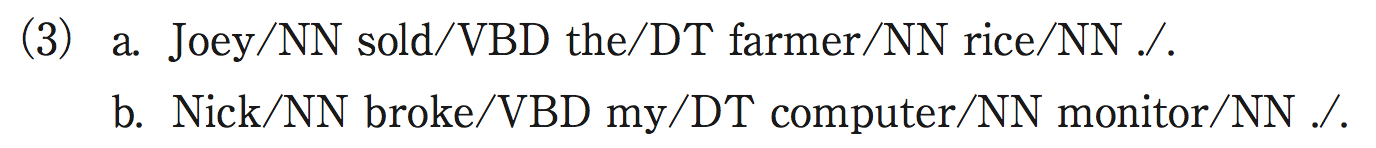

In [1]:
from IPython.display import Image
Image(filename='IMG/7-9.png', width=500)

最初の例については、farmerとriceが２つに分けられるが<br>
次の文章では、computerとmonitorが１つのチャンクになることに注意。<br>
したがって、品詞タグを使うだけでなく、単語の内容を用いることが重要になる。<br>

単語の内容に関する情報を利用するために、文のチャンキングに分類器ベースのタガーを利用する。<br>
分類器ベースのチャンカは<br>
文中の単語にIOBタグを割り当て、そのタグをチャンクに変換する。<br>

以下に分類器ベースのチャンカをみる。<br>

### <font color='blue'>連続分類器を利用した名詞句チャンキング</font>

In [2]:
import nltk

class ConsecutiveNPChunkTagger(nltk.TaggerI):
    
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='megam', trace=0)
    
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)
    
class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

次に素性抽出器を定義する。<br>

In [3]:
# 素性抽出器の定義
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos" : pos}

In [4]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='IIS', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [5]:
# ウォールストリート・ジャーナルのコーパスのimport
from nltk.corpus import conll2000

# 訓練用に文章からIBOフォーマットのNPチャンクのみの抜き出し
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
# テスト用にIBOフォーマットからNPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [6]:
# chunker = ConsecutiveNPChunker(train_sents)

In [13]:
import pickle
import os

"""
# np_chunkerディレクトリを作成し、pkl_objectsサブフォルダを作成
dest = os.path.join('np_chunker', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

# pkl_objectsサブフォルダに学習済みのclassifierのpklの保存
pickle.dump(chunker, open(os.path.join(dest, 'np_chunker_0.pkl'), 'wb'), protocol=4)
"""

"\n# np_chunkerディレクトリを作成し、pkl_objectsサブフォルダを作成\ndest = os.path.join('np_chunker', 'pkl_objects')\nif not os.path.exists(dest):\n    os.makedirs(dest)\n\n# pkl_objectsサブフォルダに学習済みのclassifierのpklの保存\npickle.dump(chunker, open(os.path.join(dest, 'np_chunker_0.pkl'), 'wb'), protocol=4)\n"

In [11]:
import os

os.chdir('np_chunker')
clf = pickle.load(open(os.path.join('pkl_objects', 'np_chunker_0.pkl'), 'rb'))

In [12]:
print(clf.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


### <font color='blue'>連続分類器を利用した名詞句チャンキングクラスと素性抽出器について詳しく見る</font>

In [14]:
# 連続分類器を利用した名詞句チャンキングクラス
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            # 品詞タグの除去
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
            train_set, algorithm='IIS', trace=0)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        
        # 単語、品詞、IBOタグの読み込み
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [15]:
# 素性抽出器の定義
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos" : pos}

In [18]:
# 訓練文章から２つの文章の抜き出し
temp_train_sents = train_sents[:2]

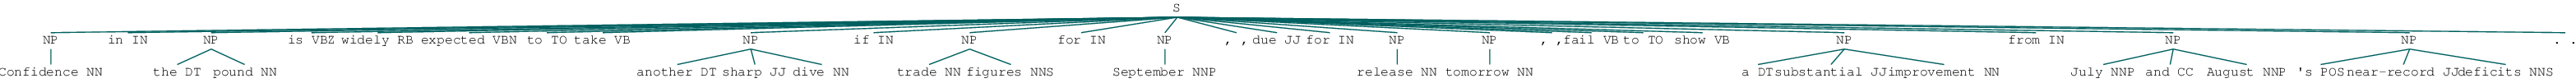

In [19]:
# 最初の文章の木構造を見る
temp_train_sents[0]

In [20]:
# 学習器の作成
chunker = ConsecutiveNPChunker(temp_train_sents)

### <font color='blue'>最初に読み込まれるConsecutiveNPChunkerクラスのプログラムについて</font>

In [24]:
# 単語、品詞、IBOタグの読み込み
tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in temp_train_sents]

In [25]:
# 表示
tagged_sents

[[(('Confidence', 'NN'), 'B-NP'),
  (('in', 'IN'), 'O'),
  (('the', 'DT'), 'B-NP'),
  (('pound', 'NN'), 'I-NP'),
  (('is', 'VBZ'), 'O'),
  (('widely', 'RB'), 'O'),
  (('expected', 'VBN'), 'O'),
  (('to', 'TO'), 'O'),
  (('take', 'VB'), 'O'),
  (('another', 'DT'), 'B-NP'),
  (('sharp', 'JJ'), 'I-NP'),
  (('dive', 'NN'), 'I-NP'),
  (('if', 'IN'), 'O'),
  (('trade', 'NN'), 'B-NP'),
  (('figures', 'NNS'), 'I-NP'),
  (('for', 'IN'), 'O'),
  (('September', 'NNP'), 'B-NP'),
  ((',', ','), 'O'),
  (('due', 'JJ'), 'O'),
  (('for', 'IN'), 'O'),
  (('release', 'NN'), 'B-NP'),
  (('tomorrow', 'NN'), 'B-NP'),
  ((',', ','), 'O'),
  (('fail', 'VB'), 'O'),
  (('to', 'TO'), 'O'),
  (('show', 'VB'), 'O'),
  (('a', 'DT'), 'B-NP'),
  (('substantial', 'JJ'), 'I-NP'),
  (('improvement', 'NN'), 'I-NP'),
  (('from', 'IN'), 'O'),
  (('July', 'NNP'), 'B-NP'),
  (('and', 'CC'), 'I-NP'),
  (('August', 'NNP'), 'I-NP'),
  (("'s", 'POS'), 'B-NP'),
  (('near-record', 'JJ'), 'I-NP'),
  (('deficits', 'NNS'), 'I-NP'),


In [27]:
tagger = ConsecutiveNPChunkTagger(tagged_sents)

In [28]:
type(tagger)

__main__.ConsecutiveNPChunkTagger